In [1]:
import numpy as np
import nitime.timeseries as nts
import nitime.analysis as nta
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
import nitime.viz as viz
import networkx as nx

In [2]:
mat = sio.loadmat('../connectome.mat', squeeze_me=True)

In [3]:
mat.keys()

['M_ll', '__header__', '__globals__', 'M_nf', '__version__', 'M_w']

In [4]:
M_nf = mat['M_nf']
M_w = mat['M_w']
M_ll = mat['M_ll']

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

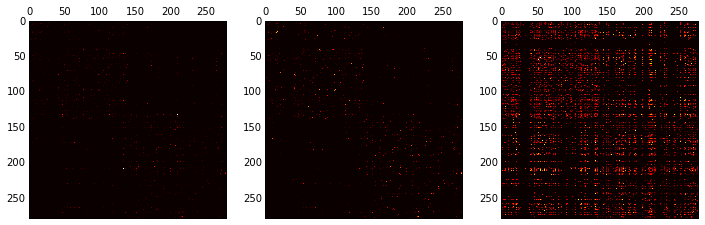

In [6]:
fig, ax = plt.subplots(1, 3)
ax[0].matshow(M_nf, cmap="hot")
ax[1].matshow(M_w, cmap="hot")
ax[2].matshow(M_ll, cmap="hot")
fig.set_size_inches([12, 12])

In [7]:
foo = np.log2(M_ll[np.tril_indices(M_ll.shape[-1])])

/Users/arokem/anaconda/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':


(array([  1.00000000e+00,   5.00000000e+00,   1.20000000e+01,
          3.90000000e+01,   9.50000000e+01,   3.21000000e+02,
          1.09800000e+03,   1.73500000e+03,   1.12200000e+03,
          1.50000000e+02]),
 array([-0.05998803,  0.85090803,  1.76180408,  2.67270014,  3.58359619,
         4.49449225,  5.4053883 ,  6.31628436,  7.22718042,  8.13807647,
         9.04897253]),
 <a list of 10 Patch objects>)

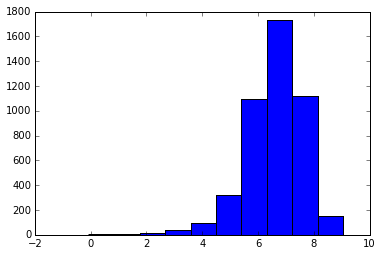

In [8]:
plt.hist(foo[np.isfinite(foo)])

In [9]:
thresholded = np.zeros_like(M_ll)
thresholded[np.log2(M_ll)>6] = 1

/Users/arokem/anaconda/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app


In [10]:
G = nx.MultiGraph(np.log2(M_ll))

/Users/arokem/anaconda/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':


In [11]:
matfc = sio.loadmat('./MRI/subj1/FC.mat', squeeze_me=True)

In [12]:
Taal_lp = matfc['Taal_lp']

In [13]:
mean_taal = np.mean(Taal_lp, -1)

In [14]:
mean_taal.shape

(1200,)

In [15]:
Taal_lp.shape

(1200, 278)

In [16]:
Taal_lp_aug = Taal_lp - mean_taal[:, None]

In [17]:
Taal_lp_aug.shape

(1200, 278)

In [18]:
ts = nts.TimeSeries(Taal_lp_aug.T, sampling_interval=.813)

In [19]:
CA = nta.CoherenceAnalyzer(ts)

In [20]:
bands = np.where(np.logical_and(CA.frequencies>0.009, CA.frequencies<0.1))

In [21]:
CA.coherence[:, :, bands[0]].shape

(278, 278, 5)

In [22]:
mean_coherence = np.mean(CA.coherence[:, :, bands[0]], -1)

In [23]:
ordering_mat = sio.loadmat('./ordering_matrices/yeo_RS7.mat')
oo = ordering_mat['yeoOrder'].squeeze()-1

In [24]:
import nitime.viz as viz

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


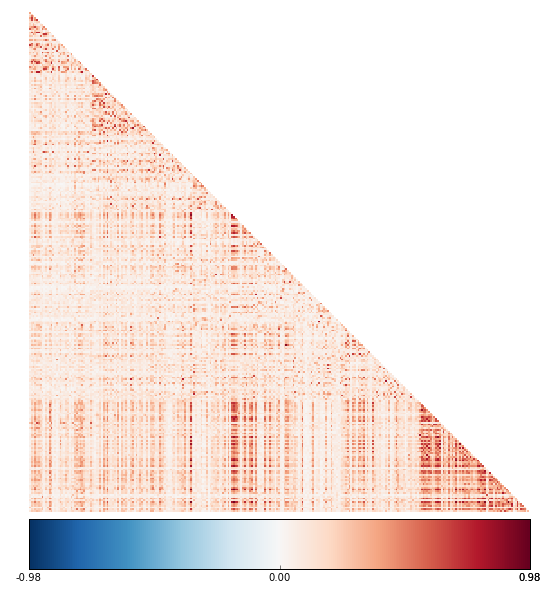

In [25]:
fig01 = viz.drawmatrix_channels(mean_coherence[oo][:, oo], size=[10., 10.], color_anchor=0)

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

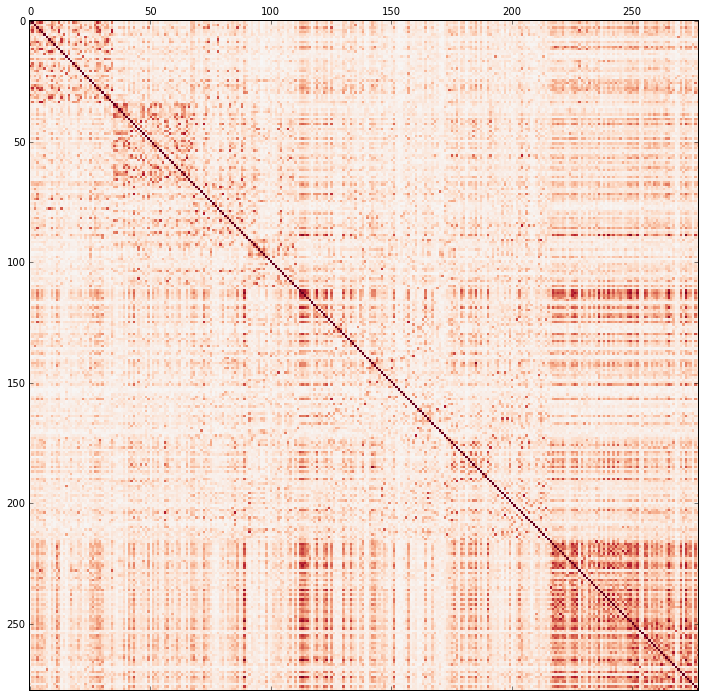

In [27]:
fig, ax = plt.subplots(1)
ax.matshow(mean_coherence[oo][:, oo], cmap='RdBu_r', vmin=-0.98, vmax=0.98)
fig.set_size_inches([12, 12])

In [28]:
CorrA = nta.CorrelationAnalyzer(ts)

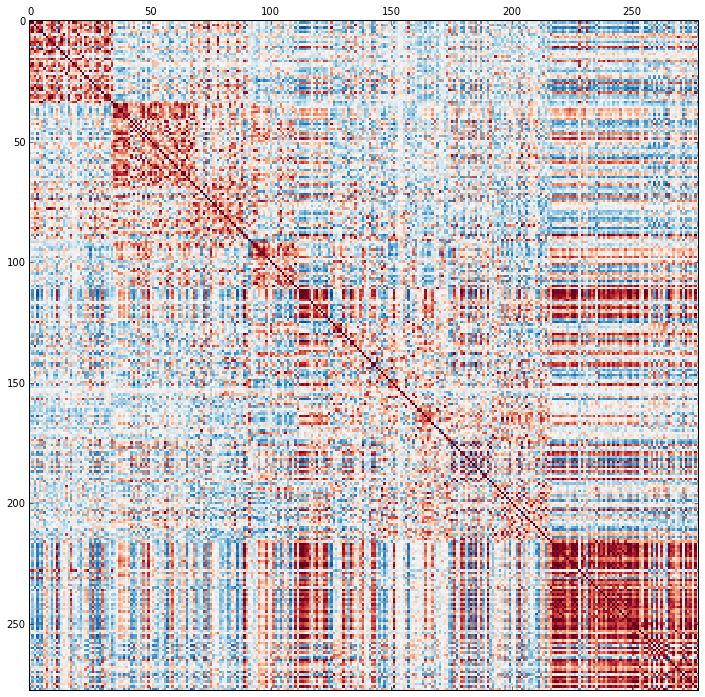

In [73]:
fig, ax = plt.subplots(1)
ax.matshow(CorrA.corrcoef[oo][:, oo], cmap='RdBu_r', vmin=-0.8, vmax=0.8)
fig.set_size_inches([12, 12])

In [67]:
adj = CorrA.corrcoef>0.4

In [68]:
import graph_tool
from numpy.random import random

g = graph_tool.Graph(directed = False)
g.add_vertex(len(adj))
edge_weights = g.new_edge_property('double')
for i in range(adj.shape[0]):
    for j in range(adj.shape[1]):
        if i > j and adj[i,j] != 0:
            e = g.add_edge(i, j)
            edge_weights[e] = adj[i,j]


In [69]:
from graph_tool.all import *
import graph_tool as gt

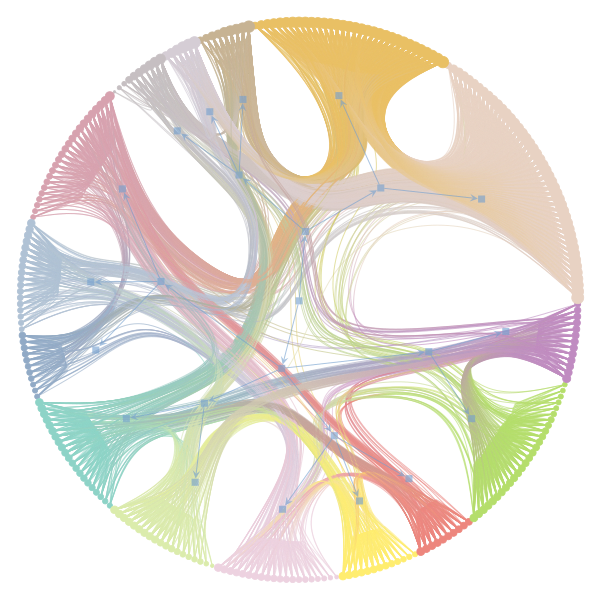

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x107990950, at 0x107990510>,
 <Graph object, directed, with 302 vertices and 301 edges at 0x1078f1810>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1078f1810, at 0x106b078d0>)

In [70]:
state = minimize_nested_blockmodel_dl(g, deg_corr=True)
gt.draw.draw_hierarchy(state, output="nested_block_model.pdf", inline=True)

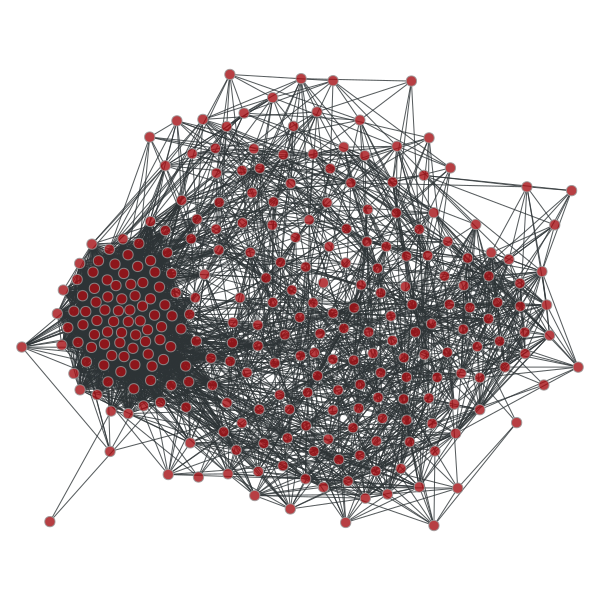

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x107990950, at 0x106b8b910>

In [71]:
import graph_tool as gt
pos = gt.draw.sfdp_layout(g)
gt.draw.graph_draw(g, pos=pos, output="tree.pdf", inline=True)

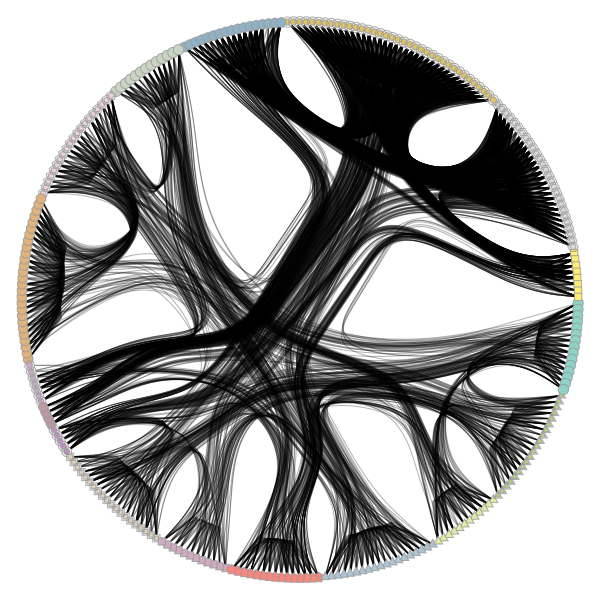

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x106ba53d0, at 0x106b8bd90>

In [72]:
g = gt.GraphView(g, vfilt=label_largest_component(g))
g.purge_vertices()
state = minimize_nested_blockmodel_dl(g, deg_corr=True)
t = get_hierarchy_tree(state)[0]
tpos = pos = gt.draw.radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
cts = gt.draw.get_hierarchy_control_points(g, t, tpos)
pos = g.own_property(tpos)
b = state.levels[0].b
shape = b.copy()
shape.a %= 14
gt.draw.graph_draw(g, pos=pos, vertex_fill_color=b, vertex_shape=shape, edge_control_points=cts,
                   edge_color=[0, 0, 0, 0.3], vertex_anchor=0, output="connectome_nested_mdl.pdf",
                   inline=True)